In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
df = pd.read_csv("../data/datasets.csv")[["text","sentiment"]]

In [7]:
df.head()

,text,sentiment
0,Развода на деньги нет\nНаблюдаюсь в Лайфклиник...,1
1,Отель выбрали потому что рядом со стадионом. О...,0
2,"Вылечили\nГноился с рождения глазик, в поликли...",1
3,Хорошее расположение.С вокзала дошли пешком.Но...,0
4,"Отличное месторасположение,прекрасный вид,особ...",1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210989 entries, 0 to 210988
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       210989 non-null  object
 1   sentiment  210989 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


In [8]:
df["sentiment"].value_counts()

sentiment
1    100792
2     55310
0     54887
Name: count, dtype: int64

<BarContainer object of 3 artists>

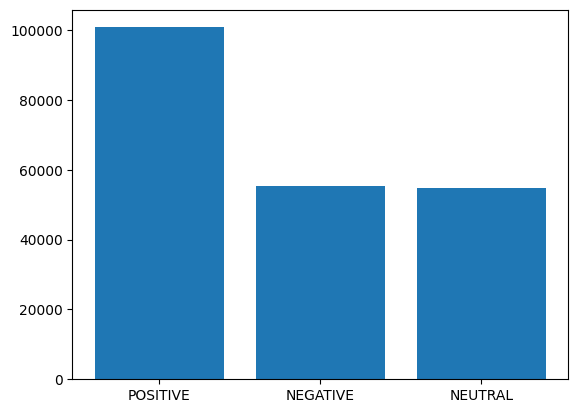

In [9]:
value_counts = df["sentiment"].value_counts()
labels_name = lambda x: "NEUTRAL" if x == 0 else "POSITIVE" if x == 1 else "NEGATIVE"
labels = [labels_name(i) for i in value_counts.index]
plt.bar(labels, df["sentiment"].value_counts().values)

In [10]:
# Статистика по символам
symbols_lens = df["text"].str.len()
symbols_lens.describe().round()

count    210989.0
mean        804.0
std        2035.0
min           3.0
25%         278.0
50%         504.0
75%         911.0
max      381498.0
Name: text, dtype: float64

<Axes: ylabel='text'>

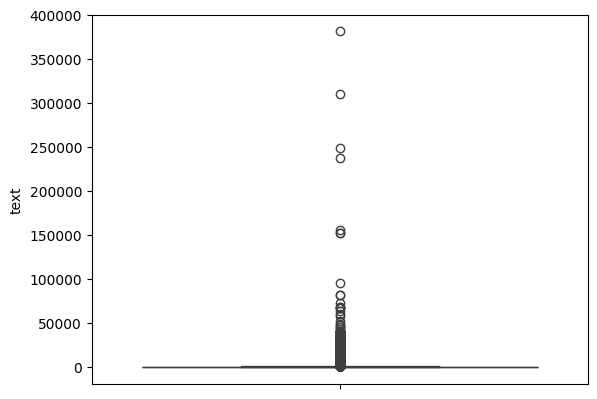

In [11]:
sns.boxplot(y=symbols_lens)

In [12]:
# Статистика по словам
def word_count(sentence):
    sentence = re.sub("[^0-9a-zA-Zа-яА-Я]+", " ", sentence)
    sentence = re.sub("  ", " ", sentence)
    words = re.split(" ", sentence)
    
    return len(words)

words_lens = df["text"].apply(word_count)
words_lens.describe().round()

count    210989.0
mean        119.0
std         269.0
min           2.0
25%          41.0
50%          76.0
75%         139.0
max       48052.0
Name: text, dtype: float64

In [25]:
words_lens.sum()

25207507

<Axes: ylabel='text'>

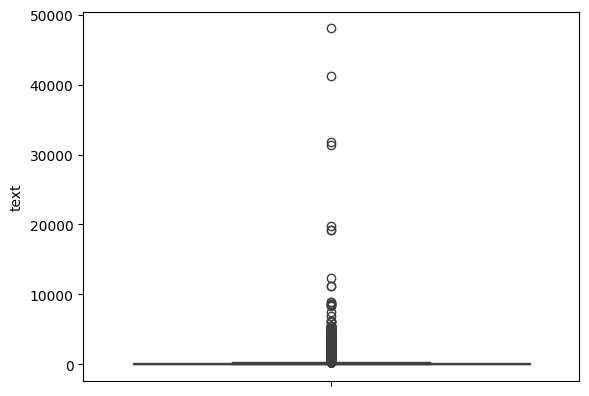

In [13]:
sns.boxplot(y=words_lens)

In [22]:
q3, q1 = np.percentile(words_lens, [75, 25])
iqr = q3 - q1
iqr
left = q1 - 1.5 * iqr
right = q3 + 1.5 * iqr
data_out = words_lens[(words_lens > right) | (words_lens < left)]
print(f"Total count: {words_lens.count()}, out: {data_out.count()} ({round(data_out.count()/words_lens.count() * 100, 2)}%)")

Total count: 210989, out: 13517 (6.41%)


## Считаем количество вхождений слов в предложения

In [10]:
russian_stopwords = stopwords.words("russian")
mystem = Mystem() 
def clean(sentence):
    sentence = re.sub("[^0-9a-zA-Zа-яА-Я]+", " ", sentence).lower()
    sentence = re.sub("  ", " ", sentence)
    sentence = re.sub("ё", "е", sentence)
    sentence = re.sub("\n", ".", sentence)
    tokens = mystem.lemmatize(sentence)
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    res_sentence = " ".join(tokens)
    return res_sentence

In [11]:
words_lemm = df["text"].apply(clean)

0    развод деньги наблюдаться лайфклиника беременн...
1    отель выбирать рядом стадион отель 4 номер бол...
2    вылечивать гноиться рождение глазик поликлиник...
3    хороший расположение вокзал доходить пешком но...
4    отличный месторасположение прекрасный вид особ...
Name: text, dtype: object

In [12]:
corpus = []
for i in range(words_lemm.shape[0]):
    corpus += words_lemm.iloc[i].split(" ")
most_common = Counter(corpus).most_common(10)

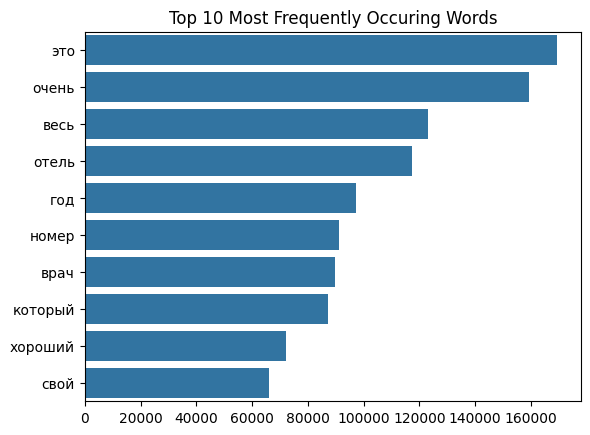

In [13]:
words = []
freq = []
for word, count in most_common:
    words.append(word)
    freq.append(count)

sns.barplot(x=freq, y=words)
plt.title('Топ 10 часто встречающихся слов')
plt.show()

## Биграммы

In [21]:
cv = CountVectorizer(ngram_range=(2,2)).fit(words_lemm)
bigrams = cv.transform(words_lemm)

In [34]:
TOP_N = 10
count_values = bigrams.sum(axis=0)
words_freq = [(word, count_values[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
bigrams_names, bigrams_freq = [name[0] for name in words_freq[:TOP_N]], [name[1] for name in words_freq[:TOP_N]]

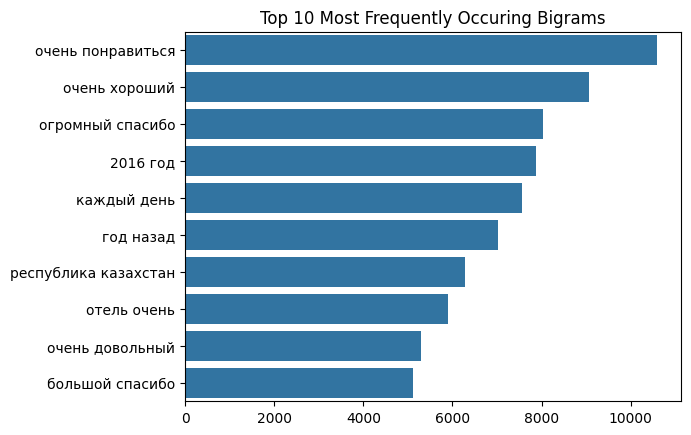

In [37]:
sns.barplot(y=bigrams_names, x=bigrams_freq)
plt.title('Топ 10 часто встречающихся Биграм')
plt.show()

In [39]:
cv = CountVectorizer(ngram_range=(3,3)).fit(words_lemm)
trigramm = cv.transform(words_lemm)

In [40]:
TOP_N = 10
count_values = trigramm.sum(axis=0)
words_freq = [(word, count_values[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
trigrams_names, trigrams_freq = [name[0] for name in words_freq[:TOP_N]], [name[1] for name in words_freq[:TOP_N]]

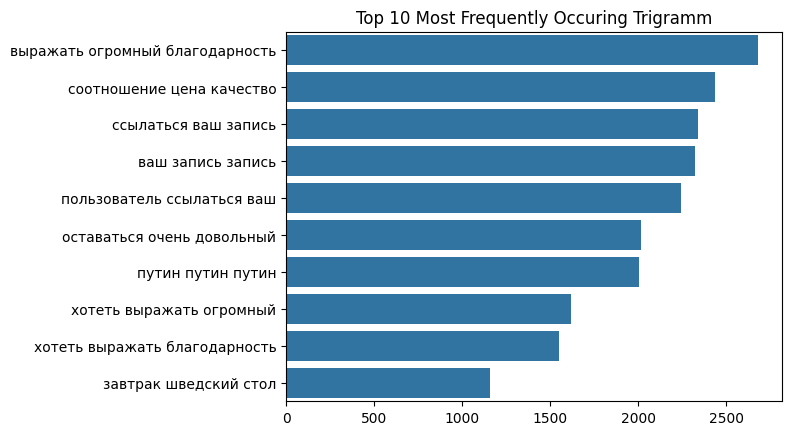

In [41]:
sns.barplot(y=trigrams_names, x=trigrams_freq)
plt.title('Топ 10 часто встречающихся Триграм')
plt.show()